In [1]:
%reset -sf

from time import time
time_start = time()

import pandas as pd
import numpy as np
import scipy as sp
import gc
import os
from matplotlib import pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # suppress tensorflow imformation messages

from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, RobustScaler
from sklearn.model_selection import train_test_split, KFold

import tensorflow as tf

from mt2 import mt2

import get_data as gd
import atlas_plot as ap
plot = ap.Plotter()

print(tf.__version__)
print(tf.config.list_physical_devices())
print()

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]



In [2]:
seed = 42  # set random seed
sampling = int(5e6)
# num_folds = 2
batch_size = 512
epochs = 512
learning_rate = 1e-4

In [3]:
np.random.seed(seed)
processor = gd.DataProcessor(sampling=sampling, processor=10)
path = "/root/data/truth/signal/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 10

['/root/data/truth/signal/CGLMP.npz', '/root/data/truth/signal/Higgs.npz', '/root/data/truth/signal/LeadLepton.npz', '/root/data/truth/signal/LeptonM.npz', '/root/data/truth/signal/LeptonP.npz', '/root/data/truth/signal/LmNu.npz', '/root/data/truth/signal/LpNu.npz', '/root/data/truth/signal/MET.npz', '/root/data/truth/signal/WmBoson.npz', '/root/data/truth/signal/WpBoson.npz', '/root/data/truth/signal/diLepton.npz', '/root/data/truth/signal/subLeadLepton.npz', '/root/data/truth/signal/xi_xyz.npz']



In [4]:
GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV
cut_pre = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss

del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

In [5]:
# inputs -> observed params
Bxy = processor.process_CGLMP(data.CGLMP)[["Bxy"]]
lep_p = processor.process_part(data.LepP)
lep_m = processor.process_part(data.LepM)
dilep_kin = processor.process_dipart(data.LepP, data.LepM)
MET = processor.process_MET(data.MET)
mt = pd.DataFrame(
    {"mt": np.sqrt(np.sum(np.square(dilep_kin[["m", "px", "py"]]), axis=1))}
)
mT2 = pd.DataFrame(
    {
        "mT2": np.sqrt(
            mt2(
                lep_m["m"],
                lep_m["px"],
                lep_m["py"],  # Visible 1: mass, px, py
                lep_p["m"],
                lep_p["px"],
                lep_p["py"],  # Visible 2: mass, px, py
                MET["MET_px"],
                MET["MET_py"],  # Missing transverse momentum: x, y
                0,
                0,  # Invisible 1 mass, invisible 2 mass
            )
        )
    }
)
pta = pd.DataFrame(
    {
        "pta": np.sqrt(
            np.square(lep_p["pt"])
            + np.square(lep_m["pt"])
            + np.square(MET["MET_px"])
            + np.square(MET["MET_py"])
        )
    }
)
# vx = pd.DataFrame({"vx": mt + 0.3 * np.sqrt(dilep_kin["m"])})
lep_kin_deta = pd.DataFrame({"d_eta": np.abs(lep_p.iloc[:, -2] - lep_m.iloc[:, -2])})
lep_kin = pd.concat(
    [lep_p.iloc[:, :4], lep_m.iloc[:, :4], 100000*lep_kin_deta["d_eta"], mt["mt"], pta["pta"]],
    axis=1,
)

mask = cut_pre

obs_kin = pd.concat(
    [
        MET.iloc[:, 1:3],
        lep_kin,
    ],
    axis=1,
)[mask]
print("obs_kin shape:", obs_kin.shape)
print(obs_kin.head(3))
print()

# targets -> interested unknowns
int_kin = Bxy[mask]
print("int_kin shape:", int_kin.shape)
print(int_kin.head(3))
print()

# del (processor, lep_p, lep_m, MET, dilep_kin, mt, vx)
# gc.collect()

obs_kin shape: (1378510, 13)
       MET_px     MET_py           E         px         py          pz  \
7   96.335650  47.095450   19.500895  -4.561588  18.924410   -1.154271   
9  -26.992604 -70.883859  164.814766  34.397141   2.031300 -161.172625   
10  44.222846 -15.383637   47.669113 -26.605045 -17.256748   35.590859   

            E         px         py         pz    d_eta         mt         pta  
7   43.361348  42.407754  -4.632000   7.767462  24.0348  62.513416  117.035693  
9   70.592648  29.001777   1.896990 -64.332027  71.1921  67.559621   88.233289  
10  90.238664 -23.868604  32.986602  80.530680  46.8398  74.393166   69.683329  

int_kin shape: (1378510, 1)
         Bxy
7   -5.57360
9   18.68250
10   6.54512



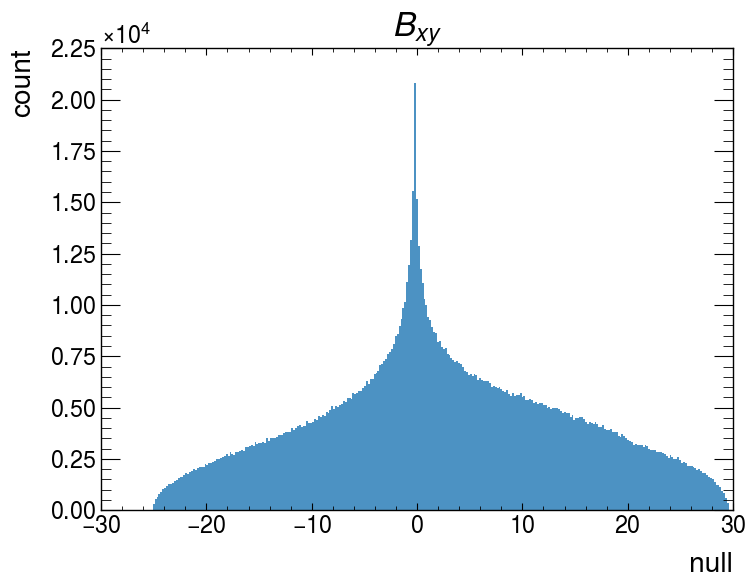

In [6]:
plt.hist(int_kin, bins=300, alpha=.8)
plt.title(r"$B_{xy}$")
plt.xlabel(r"null")
plt.ylabel("count")
plt.show()

In [7]:
SCALAR_int = StandardScaler()
int_kin = SCALAR_int.fit_transform(int_kin)

SCALAR_obs = StandardScaler()
obs_kin = SCALAR_obs.fit_transform(obs_kin)

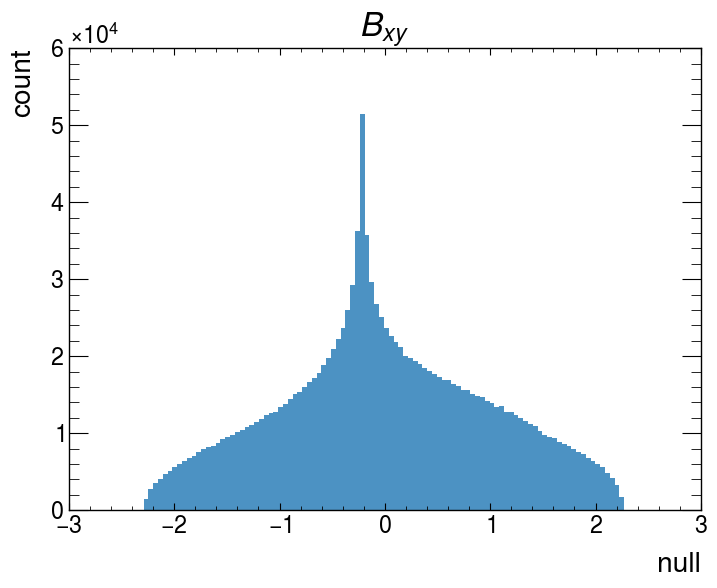

In [8]:
plt.hist(int_kin, bins=100, alpha=.8)
plt.title(r"$B_{xy}$")
plt.xlabel("null")
plt.ylabel("count")
# plt.xlim([0,0.5])
plt.show()

In [9]:
n = int(1e2)
step = (int_kin.max() - int_kin.min())/n
intervals = [int_kin.min() + i*step for i in range(n)]

sampling = int(1e3)
indices_arr = np.empty((n-1, sampling), dtype=int)
for i in range(n-1):
    try:
        indices_arr[i] = np.random.choice(np.where((intervals[i]<int_kin)*(int_kin<=intervals[i+1]))[0], size=sampling, replace=False)
    except ValueError:
        print("Cannot take a larger sample than population when 'replace=False")

In [10]:
# indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.4,
    test_size=0.6,
    random_state=seed,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=42
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)
print()

X (Interest)
Training data shape: (39600, 13);
Validing data shape: (29700, 13);
Testing data shape: (29700, 13).
Y (Observed)
Training data shape: (39600, 1);
Validing data shape: (29700, 1);
Testing data shape: (29700, 1).



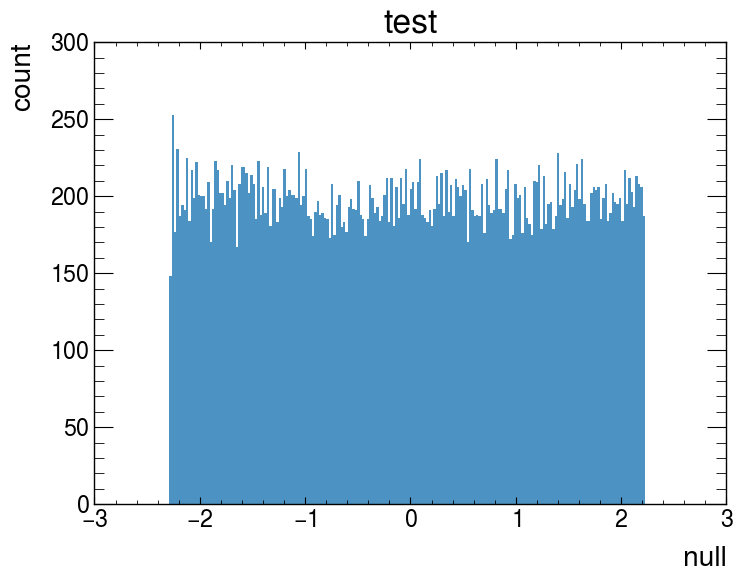

In [11]:
plt.hist(train_y, bins=200, alpha=.8)
plt.title(r"test")
plt.xlabel("null")
plt.ylabel("count")
# plt.xlim([0,0.5])
plt.show()

In [12]:
# Define a new activation function
def custom_activation(x):
    return x * tf.keras.backend.sigmoid(x)


# Define the model.
def build_model():
    # Input layer
    inputs = tf.keras.layers.Input(shape=(train_x.shape[-1],))
    x = tf.keras.layers.Flatten()(inputs)

    # Hidden tf.keras.layers
    x = tf.keras.layers.Dense(units=64, activation="elu")(x)
    x = tf.keras.layers.Dense(units=64, activation="elu")(x)
    x = tf.keras.layers.Dense(units=16, activation="elu")(x)
    x = tf.keras.layers.Dense(units=16, activation="elu")(x)
    x = tf.keras.layers.Dense(units=4, activation="elu")(x)
    x = tf.keras.layers.Dense(units=4, activation="elu")(x)

    # Last dense layer
    outputs = tf.keras.layers.Dense(units=train_y.shape[-1], activation="linear")(x)

    # Compile model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
    )

    # Summarize the model
    model.summary()

    return model

In [13]:
model = build_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 flatten (Flatten)           (None, 13)                0         
                                                                 
 dense (Dense)               (None, 64)                896       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 4)                 68    

In [14]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-6,
    patience=10,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

# Fit the model
history = model.fit(
    x=train_x,
    y=train_y,
    validation_data=(valid_x, valid_y),
    epochs=epochs,
    batch_size=batch_size,
    verbose=2,
    callbacks=[stop_early],
)

Epoch 1/512
78/78 - 4s - loss: 1.8008 - val_loss: 1.6629 - 4s/epoch - 47ms/step
Epoch 2/512
78/78 - 0s - loss: 1.6628 - val_loss: 1.6161 - 417ms/epoch - 5ms/step
Epoch 3/512
78/78 - 0s - loss: 1.6260 - val_loss: 1.5877 - 413ms/epoch - 5ms/step
Epoch 4/512
78/78 - 0s - loss: 1.5990 - val_loss: 1.5656 - 423ms/epoch - 5ms/step
Epoch 5/512
78/78 - 0s - loss: 1.5762 - val_loss: 1.5439 - 422ms/epoch - 5ms/step
Epoch 6/512
78/78 - 0s - loss: 1.5548 - val_loss: 1.5228 - 409ms/epoch - 5ms/step
Epoch 7/512
78/78 - 0s - loss: 1.5353 - val_loss: 1.5041 - 425ms/epoch - 5ms/step
Epoch 8/512
78/78 - 0s - loss: 1.5181 - val_loss: 1.4870 - 417ms/epoch - 5ms/step
Epoch 9/512
78/78 - 0s - loss: 1.5035 - val_loss: 1.4733 - 418ms/epoch - 5ms/step
Epoch 10/512
78/78 - 0s - loss: 1.4907 - val_loss: 1.4622 - 404ms/epoch - 5ms/step
Epoch 11/512
78/78 - 0s - loss: 1.4792 - val_loss: 1.4525 - 407ms/epoch - 5ms/step
Epoch 12/512
78/78 - 0s - loss: 1.4705 - val_loss: 1.4447 - 414ms/epoch - 5ms/step
Epoch 13/512
78

In [15]:
# # Define per-fold score containers
# acc_per_fold = []
# loss_per_fold = []

# # Define the K-fold Cross Validator
# kfold = KFold(n_splits=num_folds, shuffle=True)

# # K-fold Cross Validation model evaluation
# fold_no = 1
# best_model = None
# best_loss = np.inf

# # Settting up early stopping callbacks
# stop_early = tf.keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     min_delta=1e-4,
#     patience=10,
#     mode="auto",
#     baseline=None,
#     restore_best_weights=True,
# )

# # Check and find the best model form k-fold cross validation (or detect wether it's overtrining or not).
# for train, valid in kfold.split(train_x, train_y):
#     # Define the model architecture
#     model = build_model()

#     # Generate a print
#     print(f"Training for fold {fold_no} ...")

#     # Fit the model
#     history = model.fit(
#         data_gen(train_x, train_y, train),
#         steps_per_epoch=len(train) // batch_size,
#         valiazdation_data=data_gen(train_x, train_y, valid),
#         validation_steps=len(valid) // batch_size,
#         epochs=epochs,
#         verbose=0,
#         callbacks=[stop_early],
#     )

#     # Generate generalization metrics
#     scores = model.evaluate(train_x[valid], train_y[valid], verbose=0)
#     print(
#         f"Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%"
#     )
#     acc_per_fold.append(scores[1] * 100)
#     loss_per_fold.append(scores[0])

#     # Check if this model is better than the previous best model
#     if scores[0] < best_loss:
#         best_loss = scores[0]
#         best_model = model
#         best_history = history

#     # Plotting training results
#     print(f"Plotting fold {fold_no} loss history...")
#     plot.plot_loss_history(history, logy=True)

#     # Increase fold number
#     fold_no = fold_no + 1

# # == Provide average scores ==
# best_model.summary()
# print(
#     f"""{'-'*72}
# Score per fold"""
# )
# for i in range(0, len(acc_per_fold)):
#     print(
#         f"""{'-'*72}
# > Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%"""
#     )
# print(
#     f"""{'-'*72}
# Average scores for all folds:
# > Accuracy: {np.mean(acc_per_fold)}% (+- {np.std(acc_per_fold)})
# > Loss: {np.mean(loss_per_fold)}
# {'-'*72}"""
# )

In [16]:
# save model
model.save("DNN_modified_m.h5", save_format="h5", overwrite=True)
# predict
pred_y = model.predict(test_x)
sig_pred = pred_y
sig_truth = test_y

/root/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


929/929 [==============================] - 1s 1ms/step


In [17]:
print(f"Truth mean: {np.mean(sig_truth[:,0]):.3f}, std: {np.std(sig_truth[:,0]):.3f}, min: {np.min(sig_truth[:,0]):.3f}, max: {np.max(sig_truth[:,0]):.3f}")

Truth mean: -0.026, std: 1.298, min: -2.290, max: 2.226


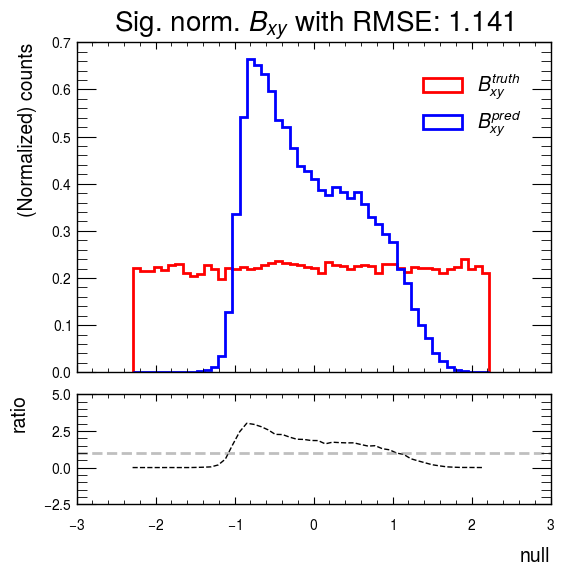

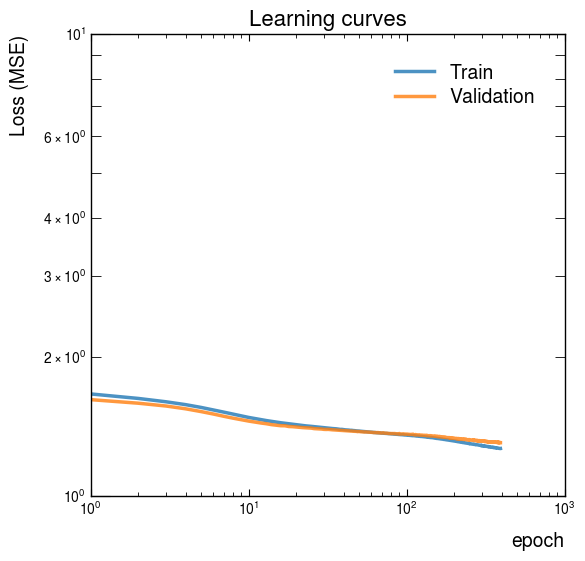

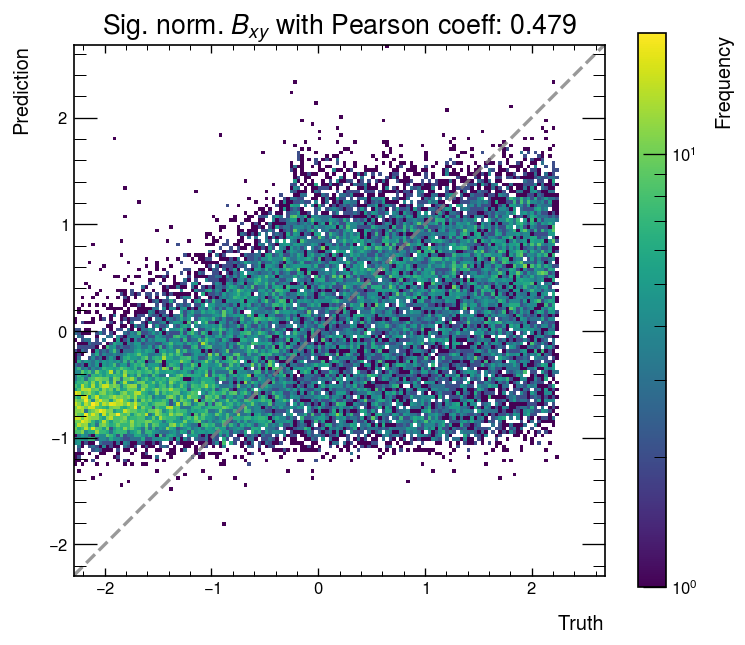

In [18]:
from sklearn.metrics import mean_squared_error

range = [-1.3, 2.4]

plot.plot_hist(
    [sig_truth[:, 0], sig_pred[:, 0]],
    [r"$B_{xy}^{truth}$", r"$B_{xy}^{pred}$"],
    r"Sig. norm. $B_{xy}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth[:,0], sig_pred[:,0])):.3f}",
    # range=range,
    xlabel=r"null",
)

plot.plot_loss_history(history, logx=True, logy=True)

plot.plot_2d_histogram(
    sig_truth[:, 0],
    sig_pred[:, 0],
    r"Sig. norm. $B_{xy}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth[:,0], sig_pred[:,0])[0]:.3f}",
    # range=range,
)

In [19]:
# TODO
STOP

NameError: name 'STOP' is not defined

In [ ]:
# from sklearn.metrics import mean_squared_error

# range = [0.43, 0.57]
35042

# plot.plot_hist(
#     [sig_truth[:, 0], sig_pred[:, 0]],
#     [r"$p_{z\ truth}^{\nu\nu}$", r"$p_{z\ pred}^{\nu\nu}$"],
#     r"Sig. norm. $p^{\nu\nu}_{z}$" + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth[:,0], sig_pred[:,0])):.3f}",
#     range=range,
#     xlabel=r"[Norm. $p_{z}$ unit]",
# )

# plot.plot_loss_history(history, logx=True, logy=True)

# plot.plot_2d_histogram(
#     sig_truth[:, 0],
#     sig_pred[:, 0],
#     r"Sig. $p_{z}^{\nu\nu}$ "
#     + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth[:,0], sig_pred[:,0])[0]:.3f}",
#     range=range,
# )

In [ ]:
# Background
processor = gd.DataProcessor(sampling=sampling, processor=10)
path = "/root/data/truth/background/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

In [ ]:
# inputs -> observed params
lep_p = processor.process_part(data.LepP)[cut_pre]
lep_m = processor.process_part(data.LepM)[cut_pre]
lep_kin = pd.concat([lep_p, lep_m], axis=1)
MET = processor.process_MET(data.MET).iloc[:, 1:3][cut_pre]
obs_kin = pd.concat([MET, lep_kin], axis=1)
print("obs_kin shape:", obs_kin.shape)
print(obs_kin.head(3))
print()

# targets -> interested unknowns
int_kin = pd.DataFrame(
    processor.process_dipart(data.NuP, data.NuM)[["pz"]][cut_pre]
)
print("int_kin shape:", int_kin.shape)
print(int_kin.head(3))
print()

del (processor, lep_p, lep_m, MET)
gc.collect()

In [ ]:
# SCALAR_obs_std_bkg = StandardScaler()
# obs_kin = SCALAR_obs_std_bkg.fit_transform(obs_kin)
SCALAR_obs_qt_bkg = QuantileTransformer(output_distribution='normal')
obs_kin = SCALAR_obs_qt_bkg.fit_transform(obs_kin)

# SCALAR_int_std_bkg = StandardScaler()
# int_kin = SCALAR_int_std_bkg.fit_transform(int_kin)
SCALAR_int_qt_bkg = QuantileTransformer(output_distribution='normal')
int_kin = SCALAR_int_qt_bkg.fit_transform(int_kin)

x, y = obs_kin[indices_arr], int_kin[indices_arr]

print(f"X:\ndata shape: {x.shape};\nY:\ndata shape: {y.shape}.")
print()

In [ ]:
y_pred = model.predict(x)
bkg_pred = y_pred
bkg_truth = y

In [ ]:
range = [
    np.max([bkg_pred[:, 0].min(), bkg_truth[:, 0].min()]),
    np.min([bkg_pred[:, 0].max(), bkg_truth[:, 0].max()]),
]

plot.plot_hist(
    [bkg_truth[:, 0], bkg_pred[:, 0]],
    [r"$E_{truth}^{\nu\nu}$", r"$E_{pred}^{\nu\nu}$"],
    "Non-resnt WW: " + r"Normalized $E$ of $\nu\nu$",
    range=range,
    xlabel=r"$E$ [GeV]",
)

plot.plot_2d_histogram(
    bkg_pred[:, 0],
    bkg_truth[:, 0],
    "Non-resnt WW: "
    + r"$E^{\nu\nu}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(bkg_truth[:,0], bkg_pred[:,0])[0]:.3f}",
    range=range,
)

In [ ]:
range = [
    np.max([bkg_pred[:, 1].min(), bkg_truth[:, 1].min()]),
    np.min([bkg_pred[:, 1].max(), bkg_truth[:, 1].max()]),
]

plot.plot_hist(
    [bkg_truth[:, 1], bkg_pred[:, 1]],
    [r"$p_{z\ truth}^{\nu\nu}$", r"$p_{z\ pred}^{\nu\nu}$"],
    r"Non-resnt WW: Normalized $p_{z}$ of $\nu\nu$",
    range=range,
    xlabel=r"$p_{z}$ [GeV]",
)

plot.plot_2d_histogram(
    bkg_truth[:, 1],
    bkg_pred[:, 1],
    "Non-resnt WW: "
    + r"$p_{z}^{\nu\nu}$"
    + f" with Pearson coeff: {sp.stats.pearsonr(bkg_truth[:,1], bkg_pred[:,1])[0]:.3f}",
    range=range,
)

time_end = time()
print(f"Time cost: {(time_end - time_start):.2f} s.")